In [1]:
import os
import numpy as np
import numba as nb
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib


C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Define function here

In [2]:
def name_encoding(table = 'click_order_user.csv', window_r = 2):
    '''
    generate output filename by input filename
    
    input:
    ------------
    table: str
        input table name
    window_r: int
        ridus of windows. Window size = 2 * window_r + 1
    
    output:
    ------------
    n_gram_table_name: str
        name of n gram csv file
        
    example:
    ------------
    >>> name_encoding(table = 'click_order_user.csv', window_r = 2)
    user_5_gram.csv
    
    '''
    name = table.replace('.csv', '').split('_')[-1]
    return '_'.join([name, str(2*window_r+1), 'gram']) + '.csv'


def command_pipeline(command):
    '''
    execute a sequence of os command
    
    input:
    ------------
    command: multiple line string
        each line is a os command
        
    example:
    ------------
    >>> command = """
    cd ./data
    data_preprocessing.exe
    >>> command_pipeline(command)
    """
    
    '''
    with open('command_pipeline_temp.bat', 'w') as f:
        f.write(command)
    os.system("command_pipeline_temp.bat")
    os.remove("command_pipeline_temp.bat")
    
def create_order_column(rowData):
    '''
    generate buy column from n gram csv
    '''
    for data in rowData:
        if data == "NONE":
            continue
        if data.split('__')[-2] == "True":
            return data
    return "NONE"


def save_model(obj, filepath):
    with open(filepath, 'wb') as f:
        joblib.dump(obj, f)
        
        
def negative_sampling(l):
    '''
    negative sampling, input number of classes, output function to do negative sampling
    
    input:
    ---------
    l: int
        number of classes
    
    output:
    ---------
    sampling: function of sample
    '''
    def sampling(rowData):
        rowData = np.array(rowData)
        negative_sample = np.random.choice(l)
        while negative_sample in rowData:
            negative_sample = np.random.choice(l)
        return negative_sample
    return sampling


## 1. Preprocessing
### 1.1 Specify arguments and configuration 

In [3]:
# ridus for n-gram window
WINDOW_R = 2
NUM_NEGATIVE = 4

DATA_PATH = "./data/" # path to store data
USER_TABLE_NAME = 'click_order_user.csv'
USER_N_GRAM_TABLE_NAME = name_encoding(USER_TABLE_NAME, WINDOW_R) # name of output n-gram file

SKU_TABLE_NAME = 'click_order_sku.csv'
SKU_N_GRAM_TABLE_NAME = name_encoding(SKU_TABLE_NAME, WINDOW_R) # name of output n-gram file


print('output n gram data into: ', USER_N_GRAM_TABLE_NAME, SKU_N_GRAM_TABLE_NAME)

output n gram data into:  user_5_gram.csv sku_5_gram.csv


### 1.2 preprocessing

1. join tables, then sort by sku_ID or user_ID
2. preprocessing using data_preprocessing.exe

In [57]:
preprocessing_command_user = """
python table_join.py
cd ./data
data_preprocessing.exe {0} sku_ID {1} {2} user_level gender education city_level purchase_power marital_status age if_order
cd ..
""".format(WINDOW_R, USER_TABLE_NAME, USER_N_GRAM_TABLE_NAME)

preprocessing_command_sku = """
cd ./data
data_preprocessing.exe {0} user_ID {1} {2} sku_ID if_order
cd ..
""".format(WINDOW_R, SKU_TABLE_NAME, SKU_N_GRAM_TABLE_NAME)





if not os.path.exists(DATA_PATH+N_GRAM_TABLE_NAME):
    command_pipeline(preprocessing_command_user)

### 1.2.1 user_encoding

In [86]:
user_5_gram = pd.read_csv('./data/user_5_gram.csv', header=None)
user_5_gram.head(5)

,0,1,2,3,4
0,NONE,NONE,4__M__3__2__2__S__26-35__,3__M__2__2__2__M__26-35__,2__F__1__1__2__M__36-45__
1,NONE,4__M__3__2__2__S__26-35__,3__M__2__2__2__M__26-35__,2__F__1__1__2__M__36-45__,NONE
2,4__M__3__2__2__S__26-35__,3__M__2__2__2__M__26-35__,2__F__1__1__2__M__36-45__,NONE,NONE
3,NONE,NONE,1__F__-1__-1__-1__U__16-25__,NONE,NONE
4,NONE,NONE,4__M__4__2__2__S__26-35__,1__U__-1__-1__-1__U__U__,NONE


### 1.2.2 label encoding

In [4]:
if not os.path.exists("./models/5_gram_user_label_encoder.pk"):
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(np.array(user_5_gram).flatten())

    save_model(label_encoder, "./models/5_gram_user_label_encoder.pk")
else:
    label_encoder = joblib.load("./models/5_gram_user_label_encoder.pk")

C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [113]:
user_5_gram = user_5_gram.apply(label_encoder.transform)
user_5_gram.head(10)

,0,1,2,3,4
0,7762,7762,7468,5897,2666
1,7762,7468,5897,2666,7762
2,7468,5897,2666,7762,7762
3,7762,7762,71,7762,7762
4,7762,7762,7664,2148,7762
5,7762,7664,2148,7762,7762
6,7762,7762,948,2148,4574
7,7762,948,2148,4574,3255
8,948,2148,4574,3255,7761
9,2148,4574,3255,7761,993


### 1.2.3 Negative sampling

In [143]:
num_classes_ = len(label_encoder.classes_)
for i in range(NUM_NEGATIVE):
    
    user_5_gram['nega_sample_' + str(i)] = user_5_gram.iloc[:, :5].apply(negative_sampling(num_classes_), axis = 1)
    
user_5_gram.head(15)

,0,1,2,3,4,nega_sample_0,nega_sample_1,nega_sample_2,nega_sample_3
0,7762,7762,7468,5897,2666,3091,7209,6728,7623
1,7762,7468,5897,2666,7762,4913,5457,799,3490
2,7468,5897,2666,7762,7762,5541,5148,7115,7718
3,7762,7762,71,7762,7762,1154,5509,6756,7543
4,7762,7762,7664,2148,7762,2928,1628,1120,3331
5,7762,7664,2148,7762,7762,1557,4865,1480,999
6,7762,7762,948,2148,4574,68,4457,7689,1482
7,7762,948,2148,4574,3255,4848,7192,1203,4849
8,948,2148,4574,3255,7761,6834,4378,3854,1107
9,2148,4574,3255,7761,993,375,2356,2264,5900


## 2 Sequence to Vector model training

In [4]:
import os 

from models import sequence2vector
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.externals import joblib

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# load n gram data
# convert n-gram data into training data
label_encoder = joblib.load("./models/5_gram_user_label_encoder.pk")

user_5_gram = pd.read_csv('./data/user_5_gram_for_word2vec.csv', index_col=None)
user_5_gram.head()

# split data into center, context and negative according to API
x_center = np.array(user_5_gram['2']).reshape(-1,1)
x_context = np.array(user_5_gram[['0', '1', '3', '4']])
x_negative = np.array(user_5_gram.iloc[:, -NUM_NEGATIVE:])
null_y = np.ones(len(x_center))

n_items = len(label_encoder.classes_)
data_size = len(x_center)

In [27]:
# Initialize sequence2vector model
# compile model

user2vec = sequence2vector.Sequence2Vector(n_items, 50, penalty=1e-5)
user2vec.compile(optimizer='adam', loss = sequence2vector.negative_log_likelihood)

In [28]:
user2vec.fit([x_center, x_context, x_negative], null_y,
             validation_split = 0.3,shuffle=True,
             batch_size=512, epochs=2)

# save embedding layer
user2vec.save_weights('./models/5_gram_user2vec_weight.h5')

Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)
Train on 3031777 samples, validate on 1299334 samples
Epoch 1/2
Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)


C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)
3023360/3031777 [============================>.] - ETA: 0s - loss: 0.4700Tensor("sequence2_vector_2/binomial_probability_2/Log:0", shape=(None, 8, None, 1), dtype=float32)
(None, 8, None, 1)
3031777/3031777 [==============================] - 27s 9us/sample - loss: 0.4699 - val_loss: 0.4719
Epoch 2/2
3031777/3031777 [==============================] - 26s 9us/sample - loss: 0.4650 - val_loss: 0.4718


## 3  Visualization of user2Vector

Import necessary library

In [31]:
import os
from models import sequence2vector

from sklearn.manifold import TSNE
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
label_encoder = joblib.load("./models/5_gram_user_label_encoder.pk")



# Load keras model
# load weight into embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
user2vec = Sequential()
user2vec.add(Embedding(len(label_encoder.classes_), 50))
user2vec.compile(optimizer='adam', loss = sequence2vector.negative_log_likelihood)
user2vec.load_weights('./models/5_gram_user2vec_weight.h5')

C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [35]:


user_vectors = pd.DataFrame() # 初始化dataframe
user_vectors['user'] = label_encoder.classes_ # 将user列设置为所有的users
user_vectors['user_encoding'] = user_vectors['user'].apply(lambda x: label_encoder.transform([x])) # 将user列encoding

user_vectors.head()

,user,user_encoding
0,-1__F__-1__1__-1__U__16-25__,[0]
1,-1__F__-1__1__-1__U__26-35__,[1]
2,-1__F__-1__2__-1__U__26-35__,[2]
3,-1__F__-1__2__-1__U__46-55__,[3]
4,-1__F__3__1__2__M__26-35__,[4]


In [37]:


user_vectors['vector'] = user_vectors['user_encoding'].apply(user2vec) # 将user转为vector
user_vectors.index = user_vectors['user'] # 设置user为index
vectors = user_vectors['vector'].apply(lambda x: np.array(x).flatten()) # 将tf.Tensor转为np.ndarray，并且设置为一维

user_vectors = pd.DataFrame(vectors.to_dict()).T

user_vectors

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
-1__F__-1__1__-1__U__16-25__,-0.136052,-0.134964,0.123127,0.107782,0.104808,0.129574,0.132403,-0.120535,-0.136539,-0.132949,...,0.130089,-0.136448,0.130897,0.134842,0.114148,0.143217,-0.133270,0.126398,0.121409,0.140251
-1__F__-1__1__-1__U__26-35__,-0.125205,-0.124159,0.112214,0.096720,0.093688,0.118715,0.121560,-0.109565,-0.125692,-0.122103,...,0.119219,-0.125689,0.120041,0.123975,0.103106,0.132431,-0.122408,0.115471,0.110429,0.129521
-1__F__-1__2__-1__U__26-35__,-0.113895,-0.112893,0.101706,0.087287,0.084489,0.107788,0.110459,-0.099244,-0.114355,-0.110972,...,0.108266,-0.114318,0.109034,0.112743,0.093232,0.120697,-0.111265,0.104766,0.100057,0.117924
-1__F__-1__2__-1__U__46-55__,-0.129737,-0.128722,0.117820,0.103283,0.100409,0.123789,0.126391,-0.115410,-0.130183,-0.126893,...,0.124271,-0.130057,0.125010,0.128639,0.109387,0.136218,-0.127196,0.120875,0.116234,0.133504
-1__F__3__1__2__M__26-35__,-0.125749,-0.124678,0.112915,0.097783,0.094859,0.119310,0.122123,-0.110341,-0.126234,-0.122664,...,0.119819,-0.126168,0.120623,0.124540,0.104034,0.132910,-0.122979,0.116146,0.111201,0.129966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4__M__4__5__3__M__26-35__,-0.128083,-0.127085,0.116281,0.102370,0.099690,0.122156,0.124742,-0.113927,-0.128530,-0.125241,...,0.122627,-0.128445,0.123365,0.126975,0.108136,0.134663,-0.125536,0.119262,0.114723,0.131936
4__M__4__5__3__M__36-45__,-0.092569,-0.091805,0.084623,0.075649,0.074049,0.088525,0.090268,-0.083141,-0.092875,-0.090615,...,0.088872,-0.092653,0.089349,0.091845,0.079402,0.096972,-0.090849,0.086680,0.083697,0.094997
4__M__4__5__3__S__26-35__,-0.101090,-0.100408,0.093810,0.084959,0.083228,0.097430,0.099018,-0.092392,-0.101366,-0.099331,...,0.097743,-0.101171,0.098181,0.100437,0.088745,0.105012,-0.099541,0.095719,0.092914,0.103262
4__U__-1__-1__-1__U__U__,0.369021,0.364302,-0.281428,-0.172874,-0.150018,-0.326378,-0.345606,0.261220,0.372218,0.348963,...,-0.329042,0.376525,-0.335083,-0.360089,-0.215503,-0.419062,0.350156,-0.301824,-0.266405,-0.402909


In [38]:
user_vectors

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
-1__F__-1__1__-1__U__16-25__,-0.136052,-0.134964,0.123127,0.107782,0.104808,0.129574,0.132403,-0.120535,-0.136539,-0.132949,...,0.130089,-0.136448,0.130897,0.134842,0.114148,0.143217,-0.133270,0.126398,0.121409,0.140251
-1__F__-1__1__-1__U__26-35__,-0.125205,-0.124159,0.112214,0.096720,0.093688,0.118715,0.121560,-0.109565,-0.125692,-0.122103,...,0.119219,-0.125689,0.120041,0.123975,0.103106,0.132431,-0.122408,0.115471,0.110429,0.129521
-1__F__-1__2__-1__U__26-35__,-0.113895,-0.112893,0.101706,0.087287,0.084489,0.107788,0.110459,-0.099244,-0.114355,-0.110972,...,0.108266,-0.114318,0.109034,0.112743,0.093232,0.120697,-0.111265,0.104766,0.100057,0.117924
-1__F__-1__2__-1__U__46-55__,-0.129737,-0.128722,0.117820,0.103283,0.100409,0.123789,0.126391,-0.115410,-0.130183,-0.126893,...,0.124271,-0.130057,0.125010,0.128639,0.109387,0.136218,-0.127196,0.120875,0.116234,0.133504
-1__F__3__1__2__M__26-35__,-0.125749,-0.124678,0.112915,0.097783,0.094859,0.119310,0.122123,-0.110341,-0.126234,-0.122664,...,0.119819,-0.126168,0.120623,0.124540,0.104034,0.132910,-0.122979,0.116146,0.111201,0.129966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4__M__4__5__3__M__26-35__,-0.128083,-0.127085,0.116281,0.102370,0.099690,0.122156,0.124742,-0.113927,-0.128530,-0.125241,...,0.122627,-0.128445,0.123365,0.126975,0.108136,0.134663,-0.125536,0.119262,0.114723,0.131936
4__M__4__5__3__M__36-45__,-0.092569,-0.091805,0.084623,0.075649,0.074049,0.088525,0.090268,-0.083141,-0.092875,-0.090615,...,0.088872,-0.092653,0.089349,0.091845,0.079402,0.096972,-0.090849,0.086680,0.083697,0.094997
4__M__4__5__3__S__26-35__,-0.101090,-0.100408,0.093810,0.084959,0.083228,0.097430,0.099018,-0.092392,-0.101366,-0.099331,...,0.097743,-0.101171,0.098181,0.100437,0.088745,0.105012,-0.099541,0.095719,0.092914,0.103262
4__U__-1__-1__-1__U__U__,0.369021,0.364302,-0.281428,-0.172874,-0.150018,-0.326378,-0.345606,0.261220,0.372218,0.348963,...,-0.329042,0.376525,-0.335083,-0.360089,-0.215503,-0.419062,0.350156,-0.301824,-0.266405,-0.402909


### 3.1.2 Dimension reduction with T-sne

In [39]:
tsne = TSNE(n_components=2)
vec_tsne = tsne.fit_transform(user_vectors)

In [48]:


df_tsne_color = pd.DataFrame()
df_tsne_color['user'] = user_vectors.index 
df_tsne_color = df_tsne_color['user'].str.split('__', expand=True)

df_tsne_color['x'] = vec_tsne[:,0]
df_tsne_color['y'] = vec_tsne[:,1]
df_tsne_color


df_tsne_color.columns = ['user_level', 'gender', 'education', 'city_level', 'purchase_power',
                           'marital_status', 'age', 'None', 'x', 'y']

In [49]:
df_tsne_color

,user_level,gender,education,city_level,purchase_power,marital_status,age,None,x,y
0,-1,F,-1,1,-1,U,16-25,,62.730949,8.419328
1,-1,F,-1,1,-1,U,26-35,,-18.987093,56.490025
2,-1,F,-1,2,-1,U,26-35,,12.182677,-5.651371
3,-1,F,-1,2,-1,U,46-55,,24.619984,32.411678
4,-1,F,3,1,2,M,26-35,,-10.948037,56.811836
...,...,...,...,...,...,...,...,...,...,...
7758,4,M,4,5,3,M,26-35,,16.009823,40.111145
7759,4,M,4,5,3,M,36-45,,-60.746826,-41.078323
7760,4,M,4,5,3,S,26-35,,-36.849209,-13.222713
7761,4,U,-1,-1,-1,U,U,,-8.689324,92.928200


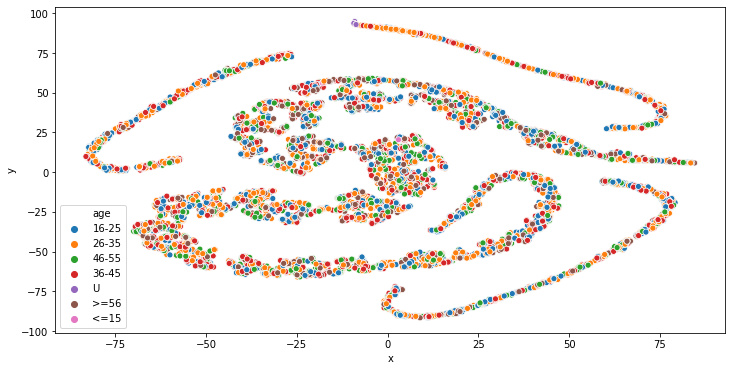

In [57]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='x', y='y', data=df_tsne_color, hue='age')

### 3.2 Cluster analysis with DBSCAN

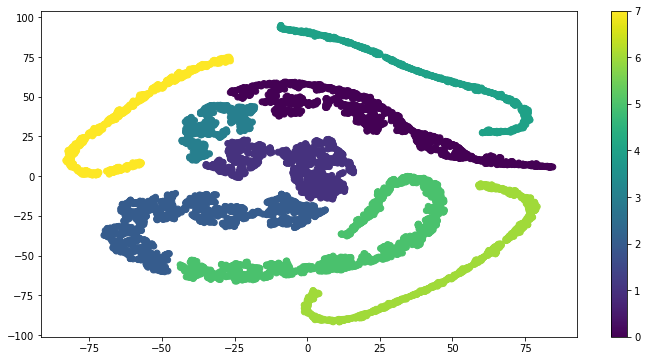

In [58]:
from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(3.5)
user_cluster = cluster_model.fit_predict(vec_tsne)

df_tsne_color['cluster'] = user_cluster

plt.figure(figsize=(12, 6))
#sns.scatterplot(x='x', y='y', data=df_tsne_color, hue='cluster')
plt.scatter(df_tsne_color['x'], df_tsne_color['y'], c=df_tsne_color['cluster'])
plt.colorbar()

In [68]:
df_tsne_color.query("cluster==4")

,user_level,gender,education,city_level,purchase_power,marital_status,age,None,x,y,cluster
13,-1,U,-1,-1,-1,U,U,,-2.147857,90.738289,4
60,10,U,-1,-1,-1,U,U,,7.732230,87.766754,4
71,1,F,-1,-1,-1,U,16-25,,0.193053,90.166565,4
72,1,F,-1,-1,-1,U,26-35,,22.830767,78.138588,4
73,1,F,-1,-1,-1,U,36-45,,46.110138,61.427757,4
...,...,...,...,...,...,...,...,...,...,...,...
7723,4,M,4,4,2,M,36-45,,18.159990,81.304802,4
7726,4,M,4,4,2,S,16-25,,63.689106,28.139959,4
7727,4,M,4,4,2,S,26-35,,30.813747,71.657074,4
7761,4,U,-1,-1,-1,U,U,,-8.689324,92.928200,4


In [69]:
user_vectors.to_csv('./output/5_gram_user_vec_v2.csv')
df_tsne_color.to_csv('./output/5_gram_user_vec_tsne_cluster_v2.csv')